In [1]:
!pip install -q tensorflow transformers
from transformers import BertTokenizer

You should consider upgrading via the 'c:\users\shefi\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from transformers import TFBertModel, BertTokenizer

In [3]:
df = pd.read_csv('updated_ielts_writing_dataset (1).csv')

In [4]:
print("Shape:", df.shape)
df.head(3)

Shape: (1436, 9)


,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,5.120347,4.103296,4.503800,5.444121,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,5.379121,4.036842,4.471886,4.373617,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,4.914584,4.583511,5.913424,5.082284,5.0


In [5]:
df.describe()

,Task_Type,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,1.552228,5.000362,5.021103,4.981544,4.985767,6.550836
std,0.497438,0.576305,0.571499,0.569995,0.571829,1.058165
min,1.000000,4.002003,4.003000,4.001776,4.000141,1.000000
25%,1.000000,4.500727,4.549623,4.500218,4.490850,6.000000
50%,2.000000,5.029919,5.027318,4.956419,5.013560,6.500000
75%,2.000000,5.488548,5.518333,5.455477,5.453455,7.000000
max,2.000000,5.997756,5.997154,5.999738,5.998640,9.000000


In [6]:
df = df.rename(columns={'Examiner_Commen': 'Comment'})

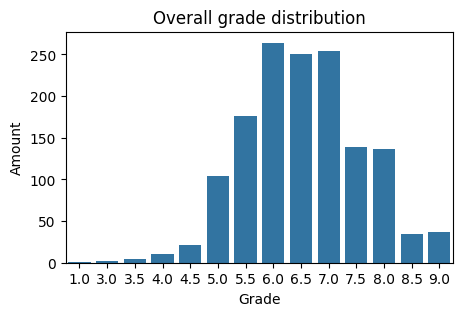

In [7]:
# Assuming 'column_name' is the name of the column you want to plot
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Overall')
plt.title(f'Overall grade distribution')
plt.xlabel('Grade')
plt.ylabel('Amount')
plt.show()

In [8]:
df = df[df['Overall'].map(df['Overall'].value_counts()) > 1]

In [9]:
# Group by "Overall" and count non-None values in "Comment"
df[df['Comment'].notna()].groupby("Overall")["Comment"].count()

Overall
5.0     8
6.0    24
7.0    17
8.0    13
Name: Comment, dtype: int64

In [10]:
df['Question'].isna().sum()

0

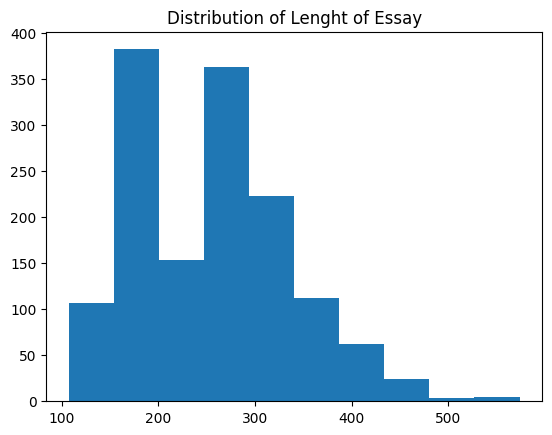

In [11]:
df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))
plt.hist(df["Length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

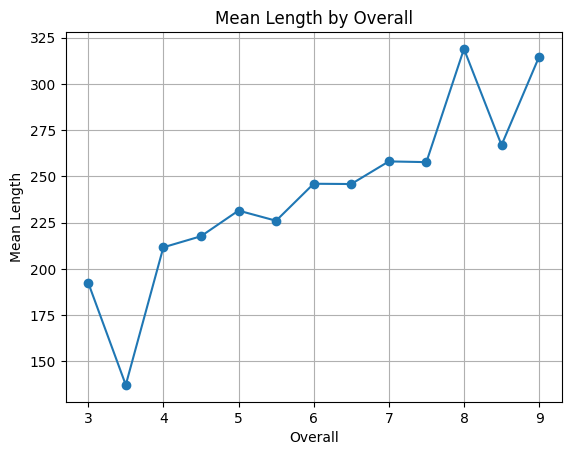

In [12]:
# Group by "Overall" and calculate the mean of "Length"
result = df.groupby(["Overall"]).agg({"Length":"mean"})

# Reset the index to make "Overall" a regular column
result.reset_index(inplace=True)

# Create a line plot
plt.plot(result["Overall"], result["Length"], marker='o', linestyle='-')
plt.xlabel("Overall")
plt.ylabel("Mean Length")
plt.title("Mean Length by Overall")
plt.grid(True)
plt.show()

In [13]:
# Transform the 'Category' column to 0s and 1s
df['Task_Type'] = (df['Task_Type'] == 2).astype(int)

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Task_Type'], prefix=['Task_Type'])

In [14]:
# All changeable variables are stored in a config dictionary for easier access
config ={
    "max_seq_length": 512,
    "bert_model_name": "bert-base-uncased",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "loss": 'mean_squared_error',
    "metrics": [MeanAbsoluteError(), RootMeanSquaredError()],
}

In [15]:
# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(config['bert_model_name'])
bert_model = TFBertModel.from_pretrained(config['bert_model_name'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Extract chosen data
X = df[['Essay',
        'Length',
        'Task_Type_0',
        'Task_Type_1']]

y = df['Overall']

# Define the indexes for different feature types
text_colums_indexes = 0
numerical_columns_indexes = [1]
binary_columns_indexes = [2, 3]

In [17]:
# Separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.values, y,
    test_size=0.1,
    shuffle=True,
    stratify=y,
    random_state=42
)

In [18]:
# Extract features
text_features_train = X_train[:, text_colums_indexes]
text_features_val = X_val[:, text_colums_indexes]

numerical_features_train = X_train[:, numerical_columns_indexes]
numerical_features_val = X_val[:, numerical_columns_indexes]

binary_features_train = X_train[:, binary_columns_indexes]
binary_features_val = X_val[:, binary_columns_indexes]

In [19]:
# Tokenize the text features with padding and truncation
input_ids_train = bert_tokenizer(list(text_features_train), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']
input_ids_val = bert_tokenizer(list(text_features_val), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']

In [20]:
# Standartize the numerical data
scaler = StandardScaler(with_mean=False)
numerical_features_train_std = scaler.fit_transform(numerical_features_train)
numerical_features_val_std = scaler.transform(numerical_features_val)

# Save the scaler to a file
with open('scaler_config.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [21]:
# Gather all the features to one dictionary
X_train_dict = {
    "input_ids": input_ids_train,
    "numerical_features": numerical_features_train_std.astype(np.float32),
    "binary_features": binary_features_train.astype(np.float32)
}

X_val_dict = {
    "input_ids": input_ids_val,
    "numerical_features": numerical_features_val_std.astype(np.float32),
    "binary_features": binary_features_val.astype(np.float32)
}

In [22]:
# Create a custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Combine BERT and Regression Head
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output
regression_output = regression_head(pooler_output)  # Custom regression head

bert_text_model = tf.keras.models.Model(inputs=input_ids, outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model, specifying the loss and metrics
bert_text_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_text_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                             

In [23]:
tf.keras.utils.plot_model(bert_text_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]    # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_model = tf.keras.models.Model(inputs=[input_ids, numerical_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

In [25]:
tf.keras.utils.plot_model(bert_num_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")
binary_features = tf.keras.layers.Input(shape=(2,), dtype=tf.float32, name="binary_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features, binary_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_binary_model = tf.keras.models.Model(inputs=[input_ids, numerical_features, binary_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_binary_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_binary_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

In [27]:
tf.keras.utils.plot_model(bert_num_binary_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# Define a callback to perform early stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,         # Minimum change in validation loss to be considered an improvement
    patience=3,          # Number of epochs with no improvement after which training will stop
    verbose=0,           # Verbosity mode (0 for silent)
    mode='auto'          # Automatically infer the direction of loss improvement
)

In [29]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert = tf.keras.callbacks.ModelCheckpoint(
    filepath='model1.h5',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert = bert_text_model.fit(X_train_dict['input_ids'], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict['input_ids'], y_val),
    callbacks=[checkpoint_callback_bert, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 5.9056 - mean_absolute_error: 1.8859 - root_mean_squared_error: 2.4302  
Epoch 1: val_loss improved from inf to 0.95925, saving model to model1.h5


c:\Users\shefi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 3987s 97s/step - loss: 5.9056 - mean_absolute_error: 1.8859 - root_mean_squared_error: 2.4302 - val_loss: 0.9592 - val_mean_absolute_error: 0.7801 - val_root_mean_squared_error: 0.9794
Epoch 2/50


In [ ]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num = tf.keras.callbacks.ModelCheckpoint(
    filepath='model2.h5',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num = bert_num_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features']], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=([X_val_dict['input_ids'], X_val_dict['numerical_features']], y_val),
    callbacks=[checkpoint_callback_bert_num, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 6.7346 - mean_absolute_error: 1.8705 - root_mean_squared_error: 2.4799
Epoch 1: val_loss improved from inf to 1.17677, saving model to model2.h5
41/41 [==============================] - 60s 1s/step - loss: 6.7346 - mean_absolute_error: 1.8705 - root_mean_squared_error: 2.4799 - val_loss: 1.1768 - val_mean_absolute_error: 0.8829 - val_root_mean_squared_error: 1.0848
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.6926 - mean_absolute_error: 1.3107 - root_mean_squared_error: 1.6409
Epoch 2: val_loss improved from 1.17677 to 1.00680, saving model to model2.h5
41/41 [==============================] - 46s 1s/step - loss: 2.6926 - mean_absolute_error: 1.3107 - root_mean_squared_error: 1.6409 - val_loss: 1.0068 - val_mean_absolute_error: 0.8128 - val_root_mean_squared_error: 1.0034
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 2.5386 - mean_absolute_error: 1.2729 - root_mean_squared

In [ ]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num_bin = tf.keras.callbacks.ModelCheckpoint(
    filepath='model3.h5',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num_bin = bert_num_binary_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features'], X_train_dict['binary_features']],
    y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict, y_val),
    callbacks=[checkpoint_callback_bert_num_bin, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 4.5042 - mean_absolute_error: 1.5494 - root_mean_squared_error: 2.0415
Epoch 1: val_loss improved from inf to 1.31509, saving model to model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 60s 1s/step - loss: 4.5042 - mean_absolute_error: 1.5494 - root_mean_squared_error: 2.0415 - val_loss: 1.3151 - val_mean_absolute_error: 0.9263 - val_root_mean_squared_error: 1.1468
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.2239 - mean_absolute_error: 1.1990 - root_mean_squared_error: 1.4913
Epoch 2: val_loss improved from 1.31509 to 0.82486, saving model to model3.h5
41/41 [==============================] - 46s 1s/step - loss: 2.2239 - mean_absolute_error: 1.1990 - root_mean_squared_error: 1.4913 - val_loss: 0.8249 - val_mean_absolute_error: 0.7193 - val_root_mean_squared_error: 0.9082
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 1.8598 - mean_absolute_error: 1.0822 - root_mean_squared_error: 1.3638
Epoch 3: val_loss improved from 0.82486 to 0.77179, saving model to model3.h5
41/41 [==============================] - 46s 1s/step - loss: 1.8598 - mean_absolute_error: 1.0822 - root_mean_squared_er

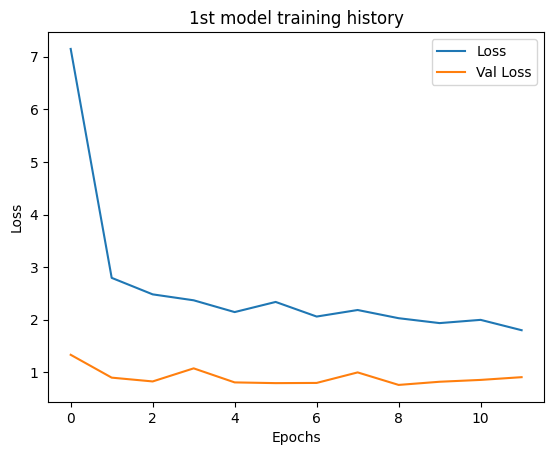

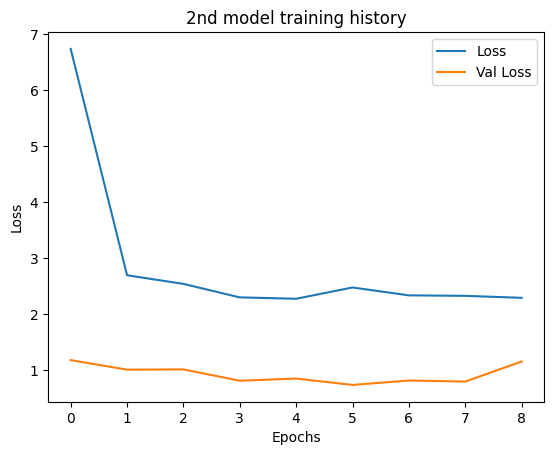

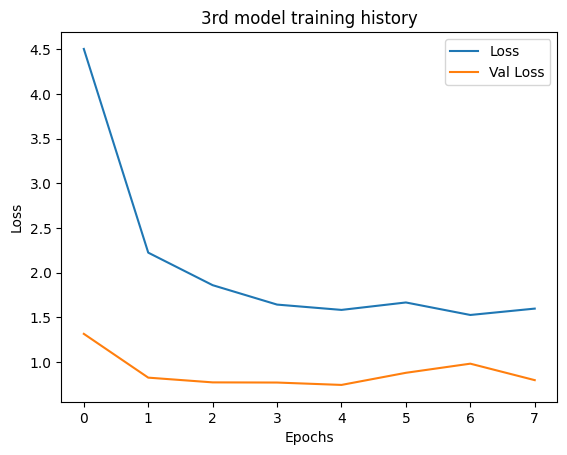

In [ ]:
# 3rd model
plt.plot(history_bert_num_bin.history["loss"])
plt.plot(history_bert_num_bin.history["val_loss"])
plt.title("Model Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

In [ ]:
bert_text_model.save('model1_v1.h5')
bert_num_model.save('model2_v1.h5')
bert_num_binary_model.save('model3_v1.h5')

bert_text_model.load_weights('model1.h5')
bert_num_model.load_weights('model2.h5')
bert_num_binary_model.load_weights('model3.h5')

In [ ]:
predictions_bert_text = bert_text_model.predict(X_val_dict['input_ids'])
bert_text_mae = mean_absolute_error(y_val, predictions_bert_text)
print(bert_text_mae)

5/5 [==============================] - 7s 698ms/step
0.6889774964915382


In [ ]:
predictions_bert_num = bert_num_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features']])
bert_num_mae = mean_absolute_error(y_val, predictions_bert_num)
print(bert_num_mae)

5/5 [==============================] - 7s 696ms/step
0.6877451108561622


In [ ]:
predictions_bert_num_bin = bert_num_binary_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features'], X_val_dict['binary_features']])
bert_num_bin_mae = mean_absolute_error(y_val, predictions_bert_num_bin)
print(bert_num_bin_mae)

5/5 [==============================] - 7s 698ms/step
0.6938385201825036


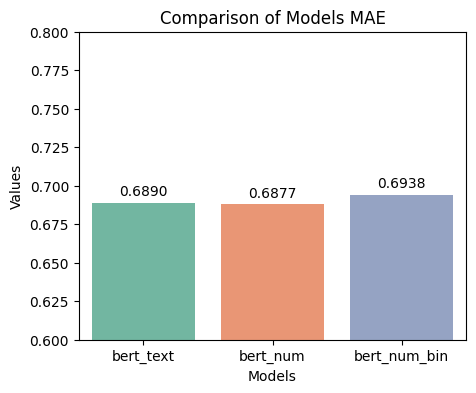

In [ ]:
# Create a data frame for the metrics and values
mae_results = pd.DataFrame({'Models': ['bert_num_bin'],
                     'Values': [bert_num_bin_mae]})

# Create a bar plot using Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x='Models', y='Values', data=mae_results, palette='Set2')
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Models MAE')

plt.ylim(0.6, 0.8)  # Set the y-axis range as needed

# Add value labels to the bars
for index, row in mae_results.iterrows():
    plt.text(index, row['Values'] + 0.005, f'{row["Values"]:.4f}', ha='center', fontsize=10)

plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack

def preprocess_data(df, vectorizer_type):
    # Separate the features and the target label
    y = df['Overall']

    # Extract the essays for text vectorization
    essays = df['Essay']

    # Initialize the appropriate vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer()
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer()

    # Vectorize the text feature 'Essay'
    X_vectorized = vectorizer.fit_transform(essays)

    # Extract the non-text features
    additional_features = df[['Length', 'Task_Type_0', 'Task_Type_1']].values

    # Combine the vectorized 'Essay' with the other features
    X_combined = hstack([X_vectorized, additional_features])

    # Split X and y into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test

for vectorizer_type in ['tfidf', 'count']:
    print(f"Using {vectorizer_type} Vectorizer")
    X_train, X_test, y_train, y_test = preprocess_data(df, vectorizer_type)

    essay_string = ["""In an age where scientific advancements shape our world, the role of education, especially in fields like physics, becomes crucial. Bu Ana, as the Head of the Physics Department, has made commendable strides in evolving the department's curriculum to meet contemporary needs. Her efforts have significantly impacted how physics is taught and perceived, preparing students for the challenges of the modern era.

Bu Ana has been pivotal in updating the curriculum to include recent developments in physics. Understanding the rapid pace at which this field changes, she has introduced subjects dealing with the latest technological advancements. This inclusion ensures that students are not just learning theories but are also aware of how these theories apply in today's world. As a result, students are more likely to be job-ready and equipped to handle real-world challenges upon graduation.

Another key aspect of Bu Ana's approach is the integration of interdisciplinary studies into the curriculum. She has collaborated with other departments to introduce courses that combine physics with other areas of study, like computer science and environmental science. This approach has opened doors for students to explore physics in new contexts, making their learning experience more diverse and enriching.

Bu Ana's initiatives have redefined the department's educational approach, bringing a fresh perspective to traditional physics studies. Her leadership in curriculum development has not only benefited current students but also set a precedent for future academic programs. Her work serves as a model for how academic leaders can adapt to changing times and prepare students for future challenges.

In conclusion, Bu Ana's contributions to revamping the physics curriculum have been substantial. Her forward-thinking approach and ability to integrate new ideas and technologies have made the department more relevant and effective in imparting education that resonates with contemporary scientific advancements. Her efforts are a testament to how visionary leadership can positively influence academic environments."""]

    # Replace this with actual essays from X_test
    essays_test = essay_string * X_test.shape[0]

    # Tokenize the essays
    tokenized_essays = bert_tokenizer(essays_test, padding='max_length', truncation=True, return_tensors='tf', max_length=512)

    # Extract numerical and binary features from X_test
    numerical_features_test = X_test[:, -3].toarray()
    binary_features_test = X_test[:, -2:].toarray()

    # Standardize numerical features
    numerical_features_test = scaler.transform(numerical_features_test).astype(np.float32)

    # Prepare inputs for the model
    model_inputs = [tokenized_essays['input_ids'], numerical_features_test, binary_features_test]

    # Make predictions
    y_pred = bert_num_binary_model.predict(model_inputs)

    print("MAE:", mean_absolute_error(y_test, y_pred))
    print(essay_string)
    print(f"The predicted grade for the new essay is: {y_pred[0]}")

Using tfidf Vectorizer
5/5 [==============================] - 4s 691ms/step
MAE: 1.5521174801720514
["In an age where scientific advancements shape our world, the role of education, especially in fields like physics, becomes crucial. Bu Ana, as the Head of the Physics Department, has made commendable strides in evolving the department's curriculum to meet contemporary needs. Her efforts have significantly impacted how physics is taught and perceived, preparing students for the challenges of the modern era.\n\nBu Ana has been pivotal in updating the curriculum to include recent developments in physics. Understanding the rapid pace at which this field changes, she has introduced subjects dealing with the latest technological advancements. This inclusion ensures that students are not just learning theories but are also aware of how these theories apply in today's world. As a result, students are more likely to be job-ready and equipped to handle real-world challenges upon graduation.\n\nA